# Price Prediction Models for Used Cars Dataset

This Jupyter notebook utilizes a cleaned and preprocessed Used Cars dataset to explore various regression models for predicting prices, including linear regression, linear models with Stochastic Gradient Descent, decision trees, random forests, eXtreme Gradient Boosting, and deep neural network. It also employs GridSearchCV to fine-tune model parameters for optimal performance. The notebook evaluates the performance of each model based on the root mean squared error.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data Prep 

The cleaned and preprocessed Used Cars dataset is downloaded.

In [2]:
df = pd.read_csv('filtered_used_cars_data.csv')

In [3]:
df.shape # the dimensions of the dataset

(1317720, 11)

The features and the target variable are defined.

In [4]:
X = df.drop('price', axis=1) # features
y = df['price'] # target variable

Split the dataset into training and testing sets.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models

### 1) Linear Regression

My initial model is linear regression due to its simplicity and efficiency in predicting outcomes

In [8]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
print("RMSE (Linear Regression):", rmse_linear)

RMSE (Linear Regression): 0.6982396947475461


### 2) Linear model with Stochastic Gradient Descent (SGD)

When using the SGDRegressor, it is important to ensure that the target variable is in the correct format. The SGDRegressor expects the target variable to be passed as a one-dimensional array. 

In [9]:
y_train_SGD = y_train.ravel()
y_test_SGD = y_test.ravel()

SGDRegressor includes several penalties (regualarization): l2, l1, and elasticnet. Lasso is a linear model trained with l1 while Ridge regression is a linear least squares with l2 regularization. Moreover,  SGDRegressor implements elasticnet regularization which give us ElasticNet regression. Therefore, SGDRegressor provides the flexibility to use any of these penalties (L1, L2, ElasticNet), which can be very handy when experimenting with different regularization techniques to find the best model for the data.

In [10]:
# params
params = {
    'alpha': [0.0001, 0.001, 0.01], # for the regularization term (penalty)
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.001],  # the initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules.
    'penalty': ['l2', 'l1', 'elasticnet'] #the regularization term
}

sgd_reg = SGDRegressor(loss='squared_error', max_iter = 10000, early_stopping = True) # the stopping criterion is 1e-3 which is the default setting 
clf_sgd = GridSearchCV(sgd_reg, params, cv=5, scoring='neg_mean_squared_error', verbose=1)
clf_sgd.fit(X_train, y_train_SGD)

print("Best Parameters for SGD:", clf_sgd.best_params_)
best_model_sgd = clf_sgd.best_estimator_

y_pred_sgd = best_model_sgd.predict(X_test)
mse_sgd = mean_squared_error(y_test_SGD, y_pred_sgd)
rmse_sgd = np.sqrt(mse_sgd)
print("RMSE (SGD):", rmse_sgd)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters for SGD: {'alpha': 0.0001, 'eta0': 0.001, 'learning_rate': 'invscaling', 'penalty': 'l1'}
RMSE (SGD): 0.6981415128396301


### 3) Decision Trees

The Decision Tree model is a straightforward and interpretable model that can handle both numerical and categorical data effectively. The hyperparameters are optimized using GridSearchCV based on the best performance on the training data.

In [11]:
param_grid_tree = {
    'max_depth': [10, 20, 30], # the maximum depth of the tree.
    'min_samples_split': [2, 10], # the minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 5], # the minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # the number of features to consider when looking for the best split:
}

model_dt = DecisionTreeRegressor()

grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_tree, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search_dt.fit(X_train, y_train)

print("Best Parameters:", grid_search_dt.best_params_)
best_model_tree = grid_search_dt.best_estimator_

y_pred_dt = best_model_tree.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print("RMSE (Decision Tree):", rmse_dt)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10}
RMSE (Decision Tree): 0.42485349649142434


### 4) Random Forests

Due to the inherent instability of Decision Tree models, a Random Forest model has been employed. However, the implementation of a grid search for the Random Forest was omitted due to its time-consuming nature. Consequently, the optimal parameters identified from the Decision Tree model were utilized in configuring the Random Forest model. 

In [12]:
best_params_dt = grid_search_dt.best_params_


model_RF = RandomForestRegressor(
    max_depth=best_params_dt['max_depth'], # the maximum depth of the tree.
    min_samples_split=best_params_dt['min_samples_split'], # the minimum number of samples required to split an internal node
    min_samples_leaf=best_params_dt['min_samples_leaf'],  # the minimum number of samples required to be at a leaf node
    max_features=best_params_dt['max_features'], # the number of features to consider when looking for the best split:
    n_estimators=100 # the number of trees (default setting)
)

model_RF.fit(X_train, y_train.ravel())
y_pred_rf = model_RF.predict(X_test)
mse_rf = mean_squared_error(y_test.ravel(), y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("RMSE (Random Forest):", rmse_rf)

RMSE (Random Forest): 0.4052508476131019


### 5) XGBoost (eXtreme Gradient Boosting)

XGBoost is chosen for its efficiency and effectiveness in handling large datasets with complex features. The hyperparameters are optimized using GridSearchCV based on the best performance on the training data.

In [13]:
param_grid_xgb = {
    'max_depth': [3, 5, 7], # the maximum tree depth for base learners
    'learning_rate': [0.01, 0.1], # boosting learning rate
    'subsample': [0.8, 1.0], # subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0] # subsample ratio of columns when constructing each tree.
}

model_xgb = XGBRegressor(n_estimators = 100)
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=1)

grid_search_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)
best_model_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("RMSE (XGBoost):", rmse_xgb)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.8}
RMSE (XGBoost): 0.38260087677244753


### Model Comparison

Various regression algorithms were evaluated to predict prices using the cleaned used car dataset. Each model's performance was quantified using the Root Mean Square Error (RMSE), which measures the average magnitude of the errors between predicted and actual values—the lower the RMSE, the better the model's performance.

In [14]:
results = [
    {"Model": "Linear Regression", "# Models": 1, "Best Parameters": "-", "RMSE": rmse_linear},
    {"Model": "SGDRegressor", "# Models": clf_sgd.cv_results_['mean_test_score'].size, "Best Parameters": clf_sgd.best_params_, "RMSE": rmse_sgd},
    {"Model": "Decision Tree", "# Models": grid_search_dt.cv_results_['mean_test_score'].size, "Best Parameters": grid_search_dt.best_params_, "RMSE": rmse_dt},
    {"Model": "Random Forest", "# Models": 1, "Best Parameters": best_params_dt, "RMSE": rmse_rf},
    {"Model": "XGBoost", "# Models": grid_search_xgb.cv_results_['mean_test_score'].size, "Best Parameters": grid_search_xgb.best_params_, "RMSE": rmse_xgb}
]

df_results = pd.DataFrame(results)

The table illustrates that a range of models was tested, from simple ones like Linear Regression to more complex ones like XGBoost. The number of model variations tested is indicated in the '# Models' column, which reflects how many different sets of hyperparameters were evaluated for each model type. For instance, 72 variations of SGDRegressor were considered, each with a unique combination of hyperparameters including alpha, eta0, and the learning rate schedule.

Best parameters for each model were identified, showcasing the optimal settings that led to the best performance in terms of RMSE for that model type. For instance, the Decision Tree model found its best parameters with a maximum depth of 30 and a minimum sample split of 10.

Each model's best performance is captured in the RMSE column, allowing for a direct comparison of how well each model was able to predict the used car prices based on their individual configurations.

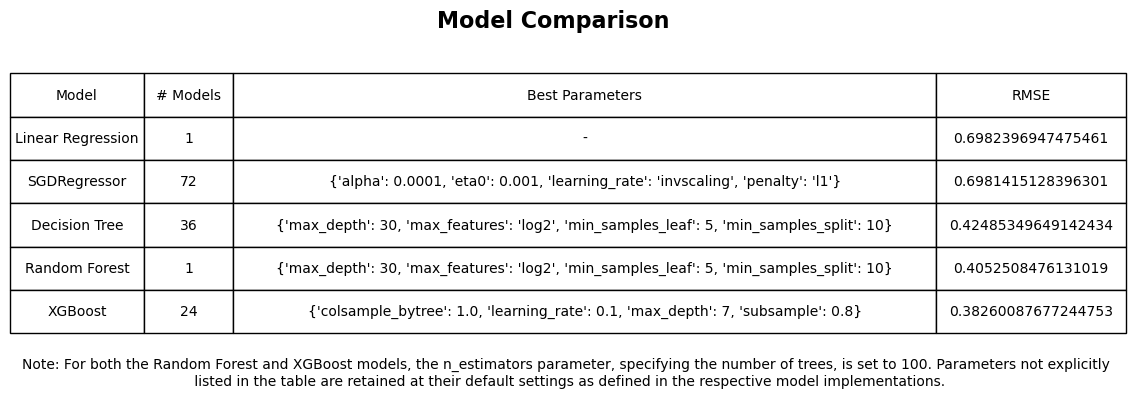

In [15]:
# Table
fig, ax = plt.subplots(figsize=(12, 4))  
ax.axis('tight')
ax.axis('off')
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
colWidths = [0.12, 0.08, 0.63, 0.17]  
the_table = ax.table(cellText=df_results.values,
                     colLabels=df_results.columns,
                     loc='center',
                     cellLoc='center',
                     colWidths=colWidths)  
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 2.6) 
footnote_text = "Note: For both the Random Forest and XGBoost models, the n_estimators parameter, specifying the number of trees, is set to 100. Parameters not explicitly \n listed in the table are retained at their default settings as defined in the respective model implementations."
ax.text(0.5, -0.05, footnote_text, transform=ax.transAxes, ha='center', va='center', fontsize=10)
plt.show()

The XGBoost model outperforms all others with the lowest RMSE value, indicating that it is the most accurate in predicting outcomes given the current data. The second-best performing model is the Random Forest, followed by the Decision Tree. The linear models, Linear Regression and SGDRegressor, while useful for their simplicity and interpretability, do not perform as well as the ensemble methods in this instance.

### Deep Neural Network

After evaluating several models including linear regression, SGDRegressor, XGBoost, random forest, and decision tree, I chose to implement a deep learning model. This decision stemmed from the necessity for a more complex model that could capture intricate patterns in the data, which simpler models might overlook. The chosen neural network is fully connected, featuring four hidden layers, each with 130 neurons, and uses ReLU activation functions. It employs a mean squared error loss function and the Adam optimizer. 

In [96]:
model_nn= tf.keras.Sequential([
    tf.keras.layers.Dense(130, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(130, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(130, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(130, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(1)  # output layer
])

model_nn.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [97]:
history = model_nn.fit(X_train, y_train, epochs=20, validation_split = 0.2, verbose=1)

Epoch 1/20
26355/26355 [==============================] - 19s 726us/step - loss: 0.3195 - val_loss: 0.1222
Epoch 2/20
26355/26355 [==============================] - 19s 717us/step - loss: 0.2749 - val_loss: 0.1061
Epoch 3/20
26355/26355 [==============================] - 19s 717us/step - loss: 0.2604 - val_loss: 0.1023
Epoch 4/20
26355/26355 [==============================] - 19s 718us/step - loss: 0.2505 - val_loss: 0.1586
Epoch 5/20
26355/26355 [==============================] - 19s 717us/step - loss: 0.2452 - val_loss: 0.0884
Epoch 6/20
26355/26355 [==============================] - 19s 715us/step - loss: 0.2405 - val_loss: 0.0895
Epoch 7/20
26355/26355 [==============================] - 19s 717us/step - loss: 0.2330 - val_loss: 0.0844
Epoch 8/20
26355/26355 [==============================] - 19s 717us/step - loss: 0.2301 - val_loss: 0.0862
Epoch 9/20
26355/26355 [==============================] - 19s 729us/step - loss: 0.2271 - val_loss: 0.0885
Epoch 10/20
26355/26355 [============

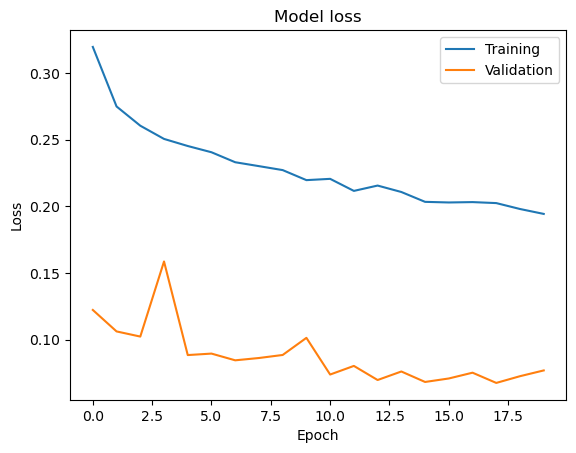

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [99]:
y_pred_nn = model_nn.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
print("RMSE (Neural Network):", rmse_nn)

8236/8236 [==============================] - 2s 249us/step
RMSE (Neural Network): 0.391432710674887


The neural network and XGBoost models show comparable performance in terms of RMSE, indicating both models have similar predictive accuracy on this dataset. The XGBoost model slightly outperforms the neural network. The neural network's slightly higher RMSE might be due to various factors, including the need for further hyperparameter tuning. In other words, the XGBoost model might be preferred for its slightly better performance and efficiency, but if the neural network can be optimized further, it could potentially improve or even surpass the performance of the XGBoost model.